<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: Mahdi Heidari
### Student ID: 99100369

# Import necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

# Define the MNIST dataset and data loader

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 118896451.74it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 92258715.78it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35510178.77it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 858093.27it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Data Visualization

In [ ]:
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

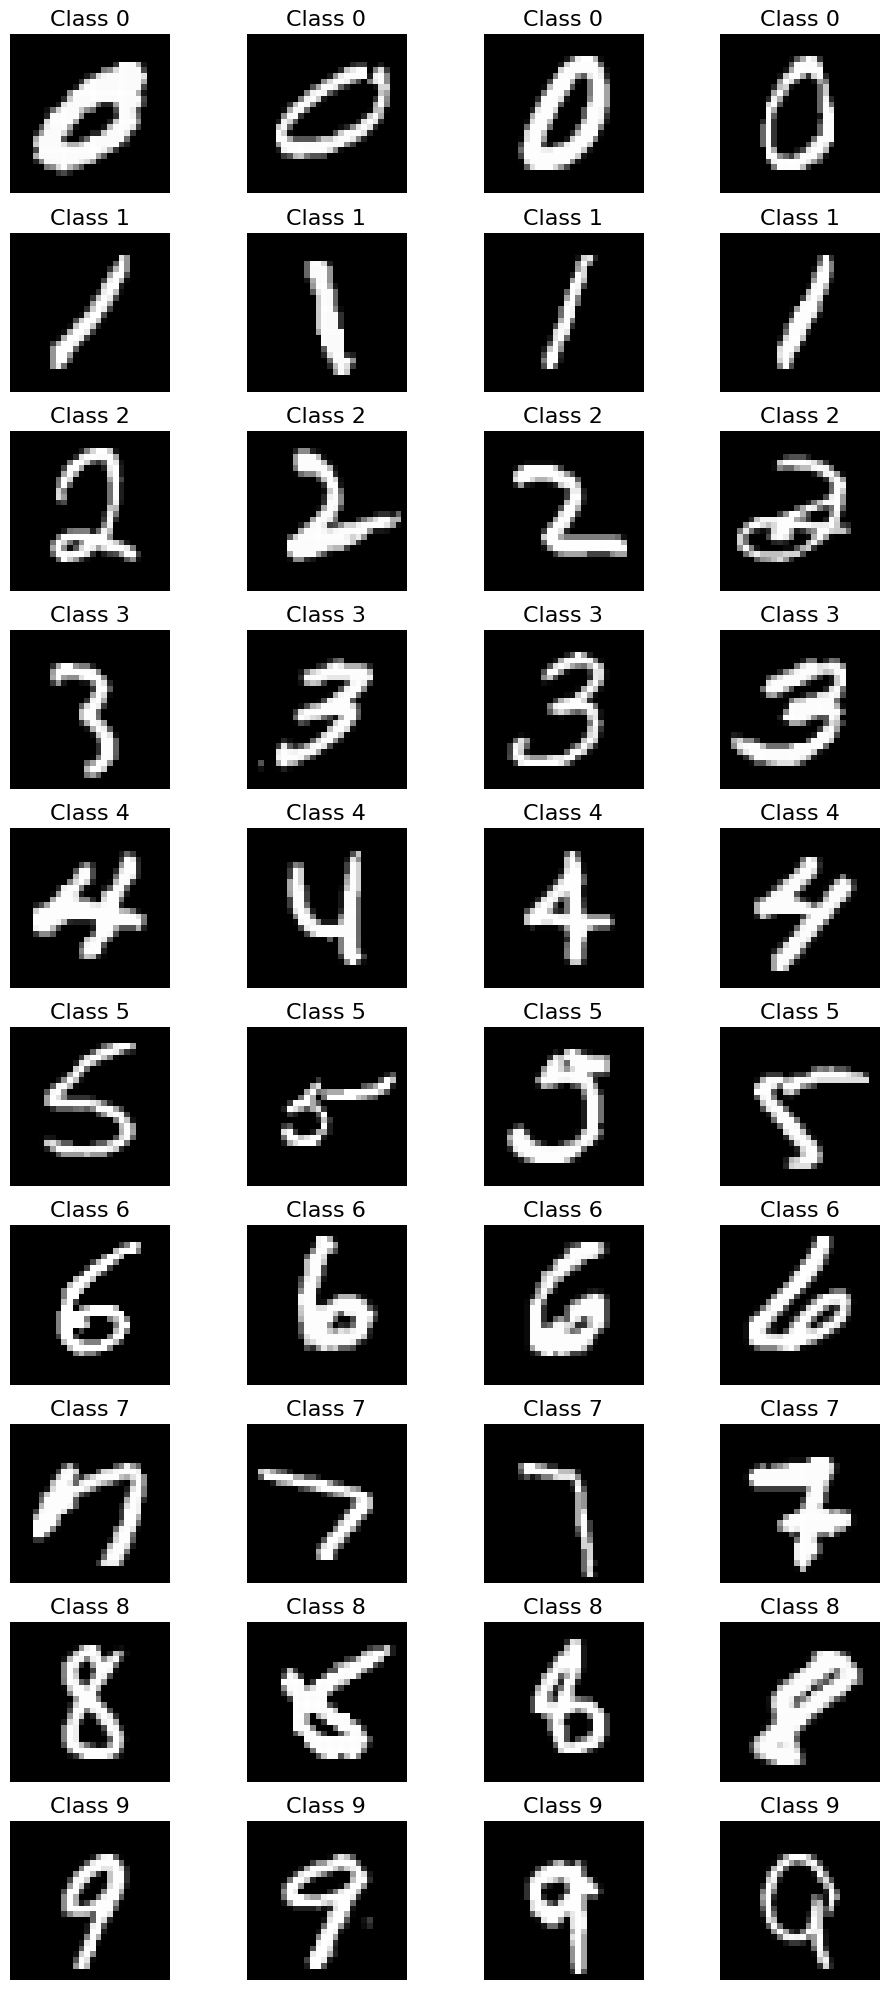

In [ ]:
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP)

Let's get started!

# 1) VAE --> MLP

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250, hidden_dim),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 250),
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.ReLU(),
            nn.Linear(500, input_dim),
            nn.Sigmoid()
        )
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        # Encode
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        # Reparameterize
        z = self.reparameterize(mu, logvar)

        # Decode
        x_recon = self.decoder(z)

        return x_recon, mu, logvar


In [ ]:
def vae_loss(recon, data, mu, logvar):
    # Reconstruction Loss (Binary Cross Entropy)
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # KL Divergence Loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total Loss (Sum of Reconstruction Loss and KL Divergence Loss)
    total_loss = reconstruction_loss + kl_divergence

    return total_loss


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

# Training Loop - VAE (MLP) with Learning Rate Decay
def train_vae_mlp(model, train_loader, num_epochs=20, initial_learning_rate=1e-3, lr_decay_step=5, lr_decay_gamma=0.1):
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)
    scheduler = StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay_gamma)

    best_loss = float('inf')
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # Forward process
            data = data.view(-1, 784)
            recon, mu, logvar = model(data)

            # Flatten the data and recon tensors
            recon = recon.view(-1, 784)

            # Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)

            # Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'VAE-MLP Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

        # Apply learning rate decay
        scheduler.step()

    # Save the best model to a file
    torch.save(best_model, 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")



##################################################
VAE-MLP Epoch [1/20], Loss: 180.97568212076823
Sample Images:


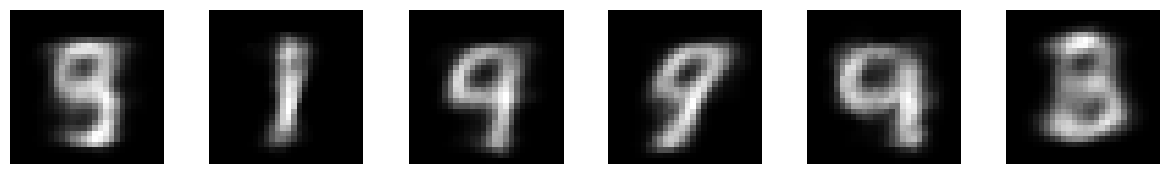


##################################################
VAE-MLP Epoch [2/20], Loss: 155.58162319335938
Sample Images:


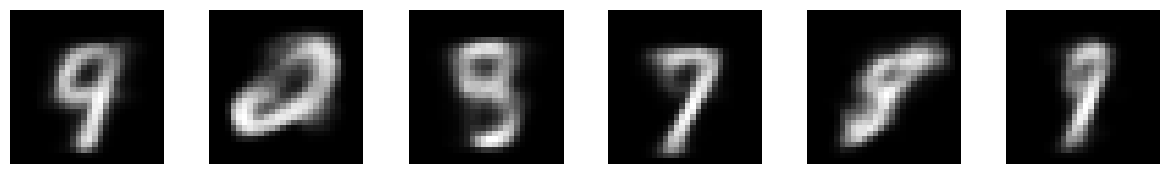


##################################################
VAE-MLP Epoch [3/20], Loss: 149.67165183919272
Sample Images:


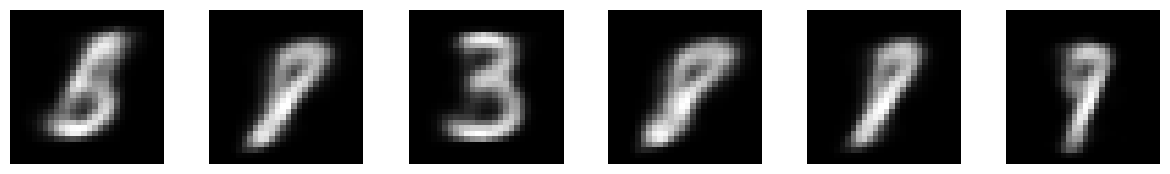


##################################################
VAE-MLP Epoch [4/20], Loss: 146.79005533040365
Sample Images:


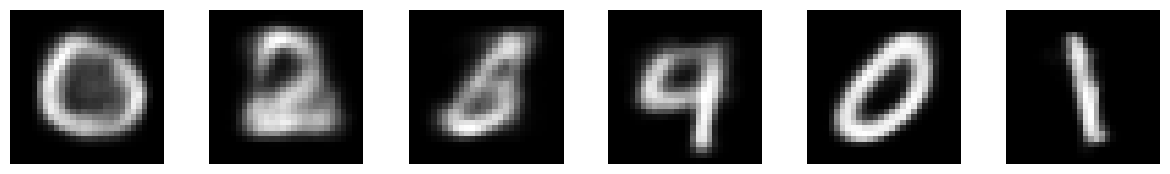


##################################################
VAE-MLP Epoch [5/20], Loss: 144.8953833902995
Sample Images:


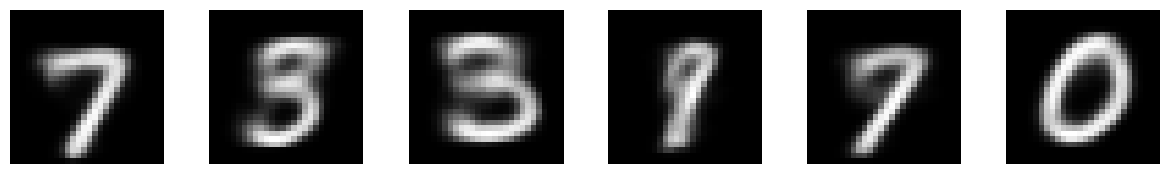


##################################################
VAE-MLP Epoch [6/20], Loss: 141.75863798014322
Sample Images:


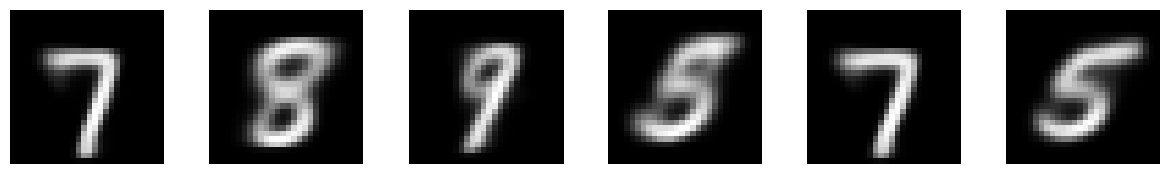


##################################################
VAE-MLP Epoch [7/20], Loss: 140.83877653808594
Sample Images:


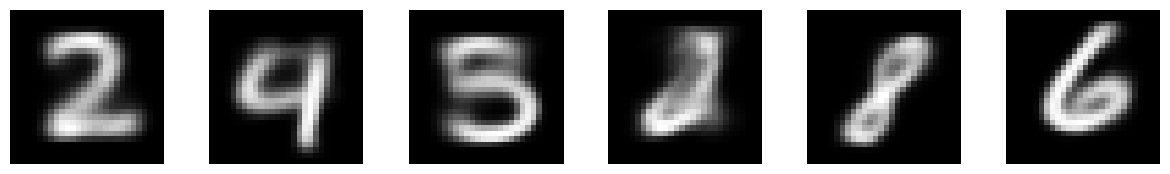


##################################################
VAE-MLP Epoch [8/20], Loss: 140.3543118001302
Sample Images:


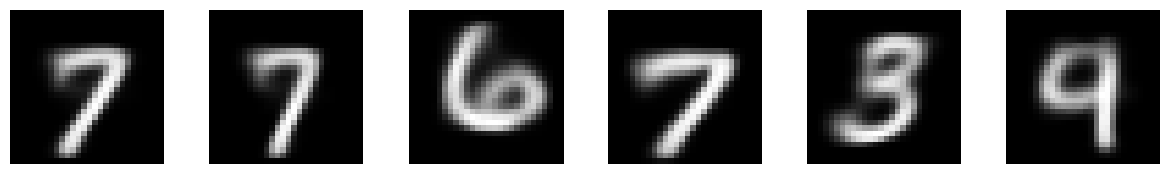


##################################################
VAE-MLP Epoch [9/20], Loss: 139.96492286783854
Sample Images:


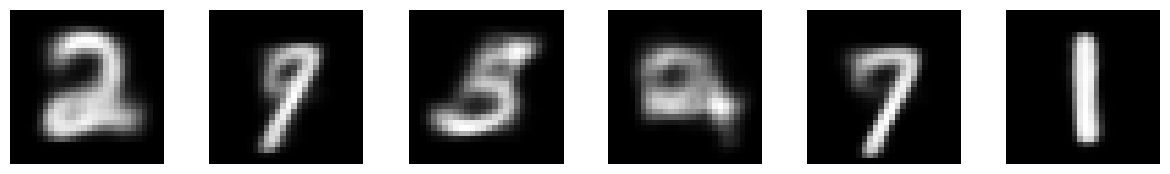


##################################################
VAE-MLP Epoch [10/20], Loss: 139.60366286621093
Sample Images:


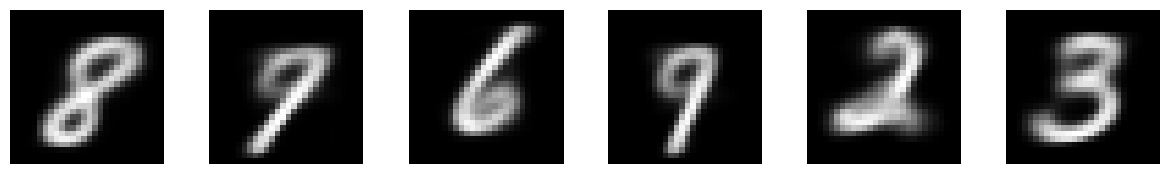


##################################################
VAE-MLP Epoch [11/20], Loss: 139.2093881266276
Sample Images:


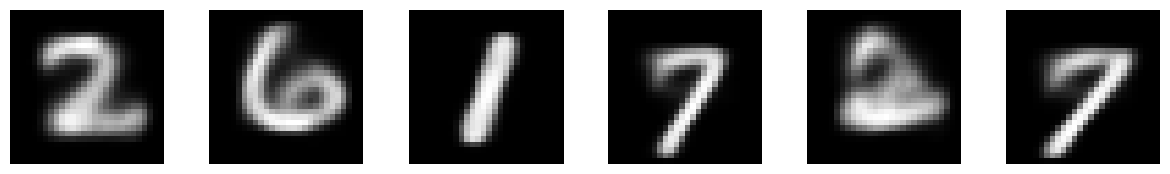


##################################################
VAE-MLP Epoch [12/20], Loss: 139.06853833007813
Sample Images:


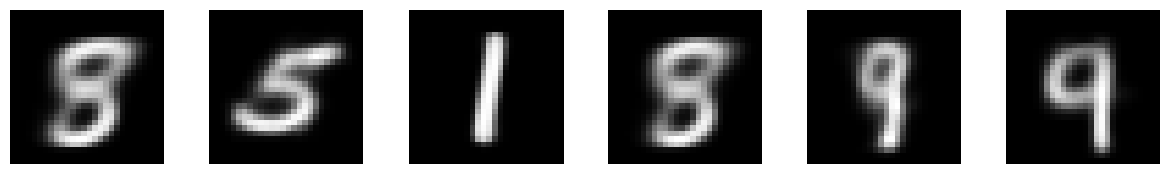


##################################################
VAE-MLP Epoch [13/20], Loss: 139.02331891276043
Sample Images:


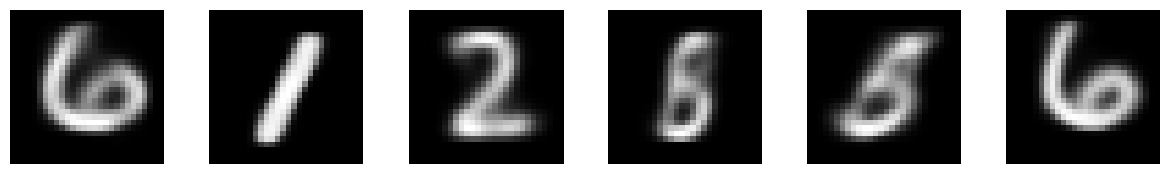


##################################################
VAE-MLP Epoch [14/20], Loss: 138.9650698893229
Sample Images:


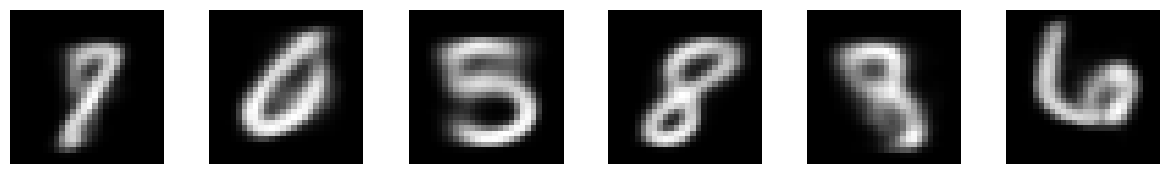


##################################################
VAE-MLP Epoch [15/20], Loss: 138.91697370605468
Sample Images:


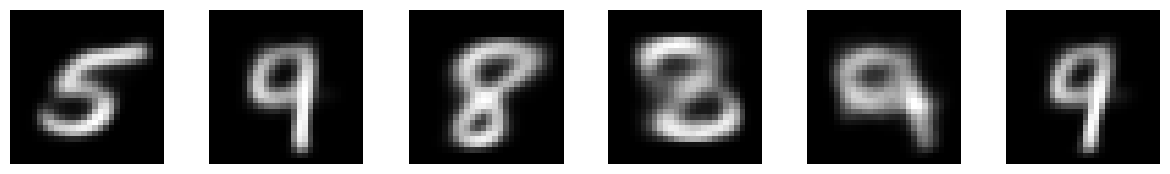


##################################################
VAE-MLP Epoch [16/20], Loss: 138.85070759277343
Sample Images:


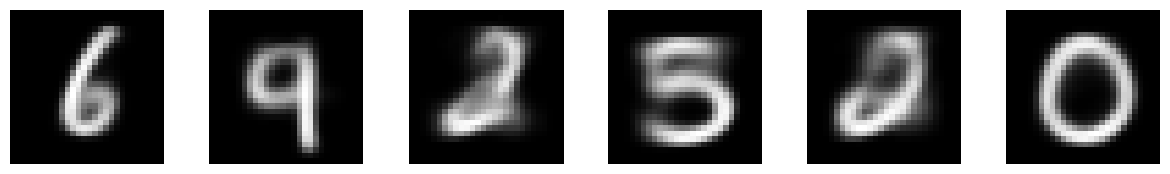


##################################################
VAE-MLP Epoch [17/20], Loss: 138.85182848307292
Sample Images:


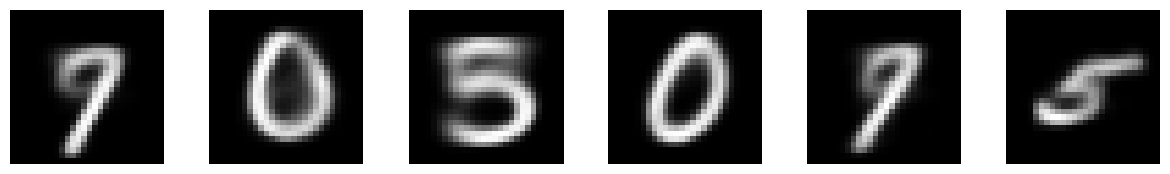


##################################################
VAE-MLP Epoch [18/20], Loss: 138.83236787923178
Sample Images:


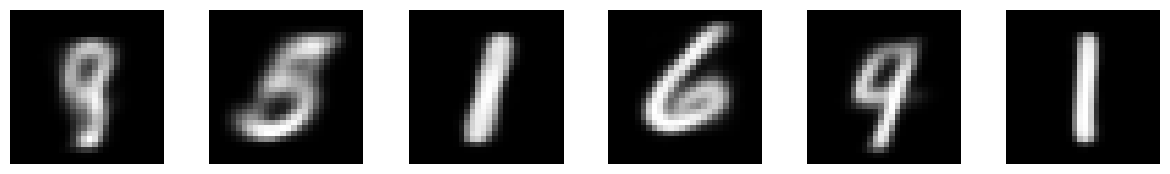


##################################################
VAE-MLP Epoch [19/20], Loss: 138.81143072916666
Sample Images:


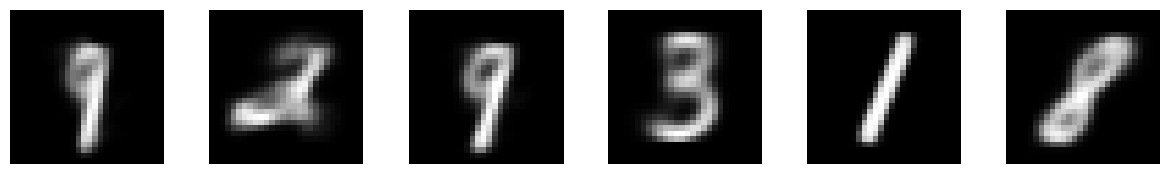


##################################################
VAE-MLP Epoch [20/20], Loss: 138.81727645670574
Sample Images:


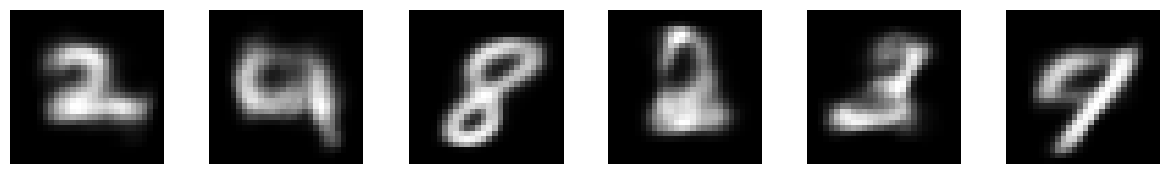

Best model saved as 'best_vae_mlp_model.pth'


In [ ]:
# Assuming train_loader is already defined

# Create an instance of VAE_MLP
vae_mlp = VAE_MLP(input_dim=784, hidden_dim=125, latent_dim=2)

# Train VAE-MLP
train_vae_mlp(vae_mlp, train_loader)


# 2) CVAE --> MLP

In [ ]:
import torch.nn.functional as F

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250, hidden_dim),  # You may adjust this layer if needed
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_class = nn.Linear(hidden_dim, num_classes)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 250),  # You may adjust this layer if needed
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.ReLU(),
            nn.Linear(500, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # Concatenate x and y before passing them to the encoder
        xy = torch.cat([x, y], dim=1)

        # Encoder
        hidden = self.encoder(xy)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)
        class_logits = self.fc_class(hidden)

        # Concatenate z and y before passing them to the decoder
        zy = torch.cat([z, y], dim=1)

        # Decoder
        reconstructed = self.decoder(zy)

        return reconstructed, mu, logvar, class_logits


In [ ]:
import torch.nn.functional as F

def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # Flatten the data tensor
    data = data.view(-1, 784)

    # Reconstruction Loss (Binary Cross Entropy)
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # KL Divergence Loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Cross-Entropy Loss for class prediction
    ce_loss = F.cross_entropy(class_logits, labels, reduction='sum')

    # Total Loss (Sum of Reconstruction, KL Divergence, and Cross-Entropy Losses)
    total_loss = reconstruction_loss + kl_divergence + ce_loss

    return total_loss


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

# Training Loop - CVAE (MLP) with Learning Rate Decay
def train_cvae_mlp(model, train_loader, num_epochs=10, initial_learning_rate=1e-3, lr_decay_step=5, lr_decay_gamma=0.1):
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)
    scheduler = StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay_gamma)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            # One-hot encode the labels
            labels_one_hot = F.one_hot(labels, num_classes=10).float()

            # Forward pass through the model and calculate the loss using cvae_loss
            recon, mu, logvar, class_logits = model(data, labels_one_hot)
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)

            # Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10
                num_samples_per_class = 1
                z = torch.randn(num_classes * num_samples_per_class, 2)
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

        # Apply learning rate decay
        scheduler.step()

    # Save the best model to a file
    torch.save(best_model, 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################
CVAE-MLP Epoch [1/10], Loss: 160.49798887532552
Sample Images:


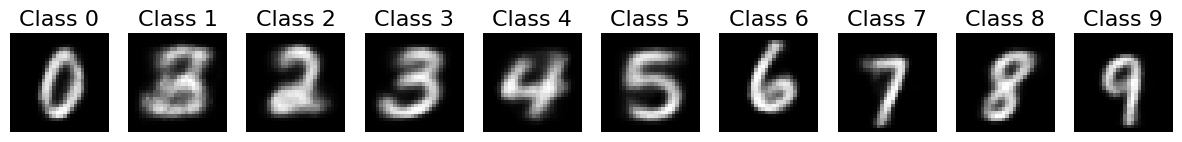


##################################################
CVAE-MLP Epoch [2/10], Loss: 137.49714997558593
Sample Images:


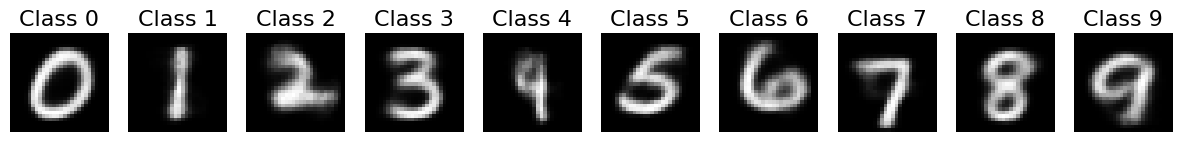


##################################################
CVAE-MLP Epoch [3/10], Loss: 134.45158836263022
Sample Images:


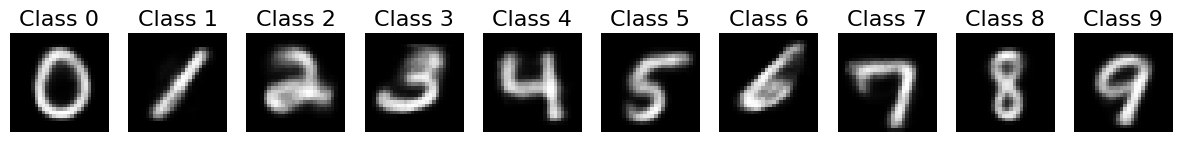


##################################################
CVAE-MLP Epoch [4/10], Loss: 132.74694431152344
Sample Images:


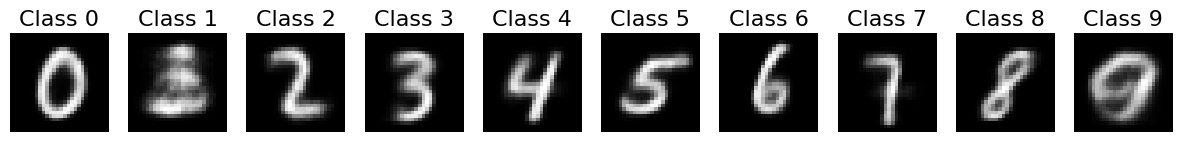


##################################################
CVAE-MLP Epoch [5/10], Loss: 131.7048338623047
Sample Images:


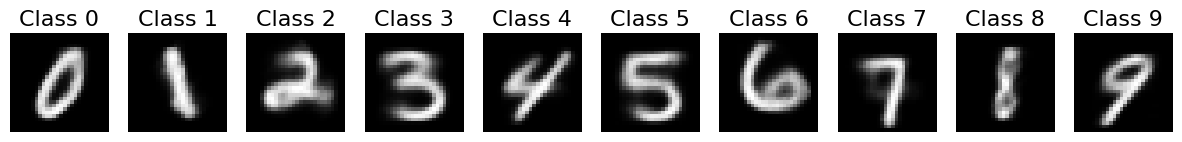


##################################################
CVAE-MLP Epoch [6/10], Loss: 129.37556315917968
Sample Images:


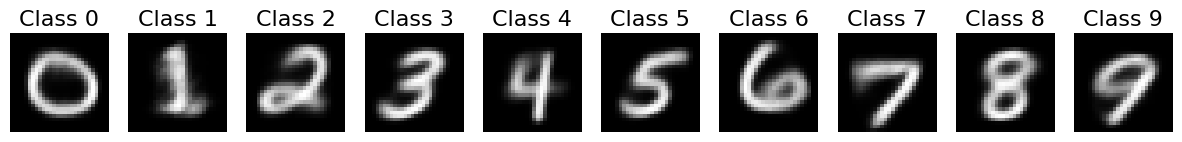


##################################################
CVAE-MLP Epoch [7/10], Loss: 128.96469974772134
Sample Images:


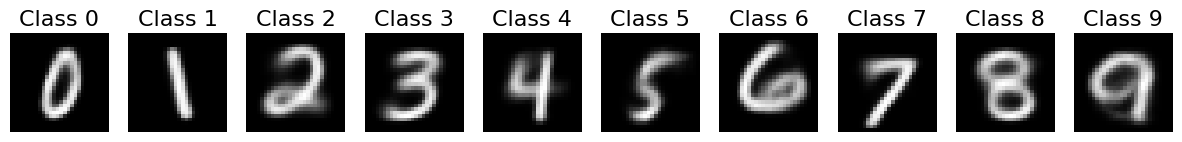


##################################################
CVAE-MLP Epoch [8/10], Loss: 128.75299265136718
Sample Images:


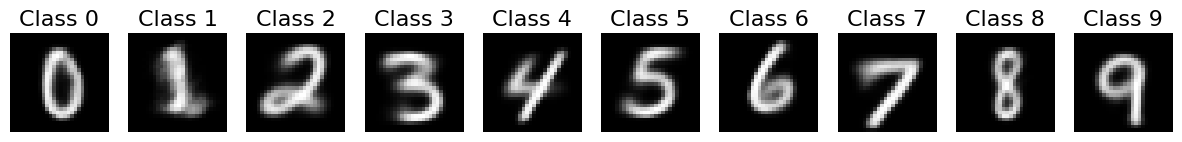


##################################################
CVAE-MLP Epoch [9/10], Loss: 128.5928801554362
Sample Images:


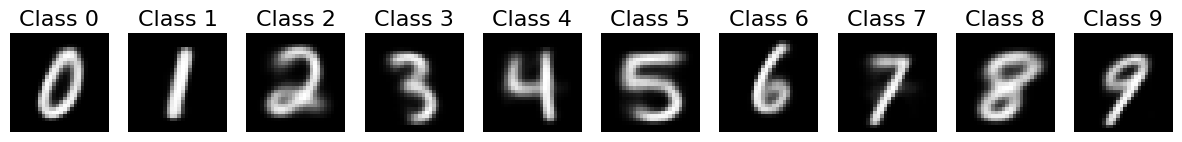


##################################################
CVAE-MLP Epoch [10/10], Loss: 128.41621639811197
Sample Images:


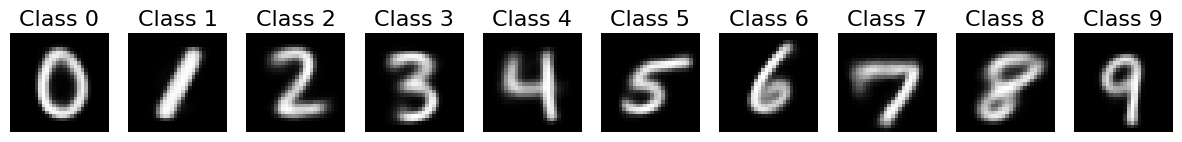

Best model saved as 'best_cvae_mlp_model.pth'


In [ ]:
# Assuming train_loader is already defined

# Create an instance of CVAE_MLP
cvae_mlp = CVAE_MLP(input_dim=784, hidden_dim=125, latent_dim=2, num_classes=10)

# Train CVAE-MLP
train_cvae_mlp(cvae_mlp, train_loader)


# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


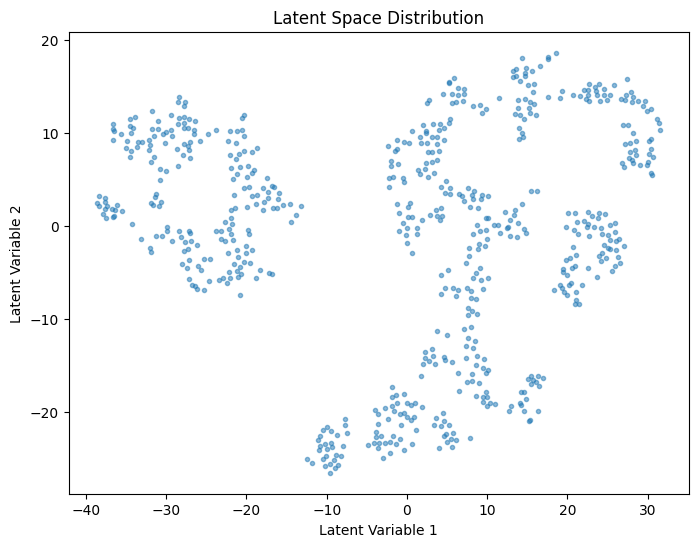

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_latent_space(model, data_loader, num_batches=10):
    model.eval()
    latent_space = []

    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(data_loader):
            data = data.view(-1, 784)
            _, mu, _ = model(data)
            latent_space.append(mu.numpy())

            if batch_idx == num_batches - 1:
                break

    latent_space = np.concatenate(latent_space, axis=0)

    # Use t-SNE for dimensionality reduction to 2D
    tsne = TSNE(n_components=2, random_state=42)
    latent_space_2d = tsne.fit_transform(latent_space)

    # Visualize the latent space distribution
    plt.figure(figsize=(8, 6))
    plt.scatter(latent_space_2d[:, 0], latent_space_2d[:, 1], marker='.', alpha=0.5)
    plt.title('Latent Space Distribution')
    plt.xlabel('Latent Variable 1')
    plt.ylabel('Latent Variable 2')
    plt.show()

# Visualize latent space for VAE (MLP)
visualize_latent_space(vae_mlp, train_loader)



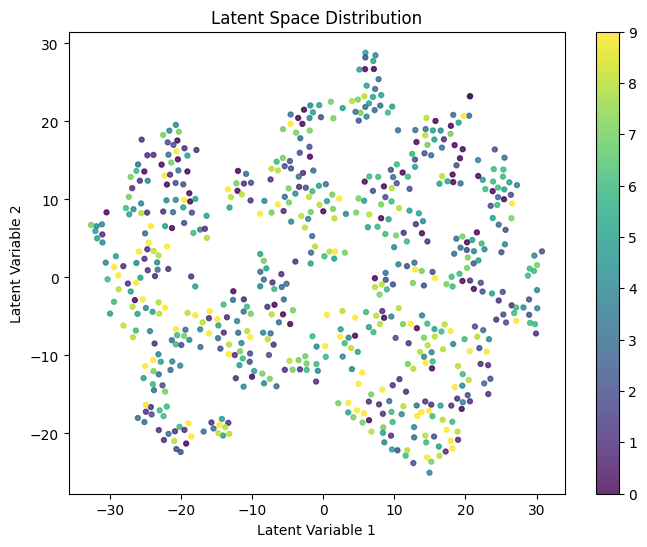

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_latent_space(model, data_loader, num_batches=10):
    model.eval()
    latent_space = []
    labels = []

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(data_loader):
            labels_one_hot = F.one_hot(label, num_classes=10).float()

            _, mu, _, _ = model(data, labels_one_hot)
            latent_space.append(mu.numpy())
            labels.append(label.numpy())

            if batch_idx == num_batches - 1:
                break

    latent_space = np.concatenate(latent_space, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Use t-SNE for dimensionality reduction to 2D
    tsne = TSNE(n_components=2, random_state=42)
    latent_space_2d = tsne.fit_transform(latent_space)

    # Visualize the latent space distribution
    plt.figure(figsize=(8, 6))
    plt.scatter(latent_space_2d[:, 0], latent_space_2d[:, 1], c=labels, cmap='viridis', marker='.', alpha=0.8, s=50)
    plt.title('Latent Space Distribution')
    plt.xlabel('Latent Variable 1')
    plt.ylabel('Latent Variable 2')
    plt.colorbar()
    plt.show()

visualize_latent_space(cvae_mlp, train_loader)



می توان دید که در مدل اول تا حد خیلی خوبی داده ها از یکدیگر جدا شده بودند و می توانیم شهودی از تفکیک پذیری آنها داشته باشیم

اما در دومی نمیتوان و داده ها خیلی مخلوط هستند

